# Dataset Construction

In [1]:
import numpy as np
import pandas as pd
from torch_geometric_temporal.signal import StaticGraphTemporalSignal, DynamicGraphTemporalSignal
import torch
from typing import Union
import glob
from natsort import natsorted
import random

# Fix random seed for ease of reproduction
seed = 42
random.seed(seed)
torch.manual_seed(seed)

class SP500CorrelationsDatasetLoader(object):
    def __init__(self, corr_name, corr_scope):
        self._read_csv(corr_name, corr_scope)

    def _load_global_corr(self, corr_name):
        return np.loadtxt(f'{corr_name}/global_corr.csv', delimiter=',')

    def _load_local_corrs(self, corr_name):
        _correlation_matrices = []
        corr_files = natsorted(glob.glob(f'{corr_name}/local_corr_*.csv'))
        for corr_file in corr_files:
            matrix = np.loadtxt(corr_file, delimiter=',')
            _correlation_matrices.append(matrix)
        return _correlation_matrices

    def _read_csv(self, corr_name, corr_scope):
        match corr_scope:
            case 'global':
                self._correlation_matrices = [self._load_global_corr(corr_name)]
            case 'local':
                self._correlation_matrices = self._load_local_corrs(corr_name)
            case 'dual':
                global_corr = self._load_global_corr(corr_name)
                self._correlation_matrices = [np.stack((global_corr, local_corr), axis=-1) for local_corr in self._load_local_corrs(corr_name)]
            case None:
                # None uses identity matrix as correlation
                # Infer dimension from a global correlation matrix
                global_corr = self._load_global_corr('pcc')
                self._correlation_matrices = [np.eye(global_corr.shape[0], global_corr.shape[1])]
        
        df = pd.read_csv('s&p500.csv')
        df = df.set_index('Date')
        data = torch.from_numpy(df.to_numpy()).to(torch.float32)

        # Round data size to nearest multiple of batch_size
        self.days_in_quarter = 64
        num_quarters = data.size(0) // self.days_in_quarter
        num_days = num_quarters * self.days_in_quarter
        data = data[:num_days]
        
        # z-score normalization with training data following GERU
        train_days = int(0.8 * num_quarters) * self.days_in_quarter
        data = (data - data[:train_days].mean(dim=0)) / data[:train_days].std(dim=0)
        data = data.numpy()

        data = data[..., np.newaxis]

        assert(not np.any(np.isnan(data)))
        self._dataset = data

    def _get_edges(self, times, overlap):
        if len(self._correlation_matrices) == 1:
            _edges = np.array(np.ones(self._correlation_matrices[0].shape[:2]).nonzero())
        else:
            _edges = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edges.append(
                    np.array(np.ones(self._correlation_matrices[corr_index].shape[:2]).nonzero())
                )
        return _edges

    def _get_edge_weights(self, times, overlap):
        if len(self._correlation_matrices) == 1:
            # Flatten the first two dimensions
            w = self._correlation_matrices[0]
            _edge_weights = w.reshape((w.shape[0] * w.shape[1],) + w.shape[2:])
        else:
            _edge_weights = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                # Flatten the first two dimensions
                w = self._correlation_matrices[corr_index]
                _edge_weights.append(
                    np.array(w.reshape((w.shape[0] * w.shape[1],) + w.shape[2:]))
                )
        return _edge_weights

    def _get_targets_and_features(self, times, overlap, predict_all):
        features = [
            self._dataset[i : i + self.batch_size, :]
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        # predict next-day stock prices
        targets = [
            (self._dataset[i+1 : i + self.batch_size+1, :, 0]).T if predict_all else (self._dataset[i + self.batch_size, :, 0]).T
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        return features, targets

    def get_dataset(self, batch_size, split) -> Union[StaticGraphTemporalSignal, DynamicGraphTemporalSignal]:
        """Returning the data iterator.
        """
        self.batch_size = batch_size

        total_times = list(range(0, self._dataset.shape[0] - self.batch_size, self.batch_size))

        if split == 'train':
            times = list(range(total_times[int(len(total_times) * 0)], total_times[int(len(total_times) * 0.8)]))
            overlap = self.batch_size
            predict_all = True
        elif split == 'val':
            times = list(range(total_times[int(len(total_times) * 0.8)], total_times[int(len(total_times) * 0.9)]))
            overlap = 1
            predict_all = False
        elif split == 'test':
            times = list(range(total_times[int(len(total_times) * 0.9)], total_times[-1] + self.batch_size))
            overlap = 1
            predict_all = False
        else:
            raise ValueError(f'Invalid split name: {split}')

        _edges = self._get_edges(times, overlap)
        _edge_weights = self._get_edge_weights(times, overlap)
        features, targets = self._get_targets_and_features(times, overlap, predict_all)
        dataset = (DynamicGraphTemporalSignal if type(_edges) == list else StaticGraphTemporalSignal)(
            _edges, _edge_weights, features, targets
        )
        return dataset

In [2]:
def get_dataset(corr_name, corr_scope):
    loader = SP500CorrelationsDatasetLoader(corr_name=corr_name, corr_scope=corr_scope)

    lag_size = 64
    train_dataset = loader.get_dataset(batch_size=lag_size * 2, split='train')
    val_dataset = loader.get_dataset(batch_size=lag_size, split='val')
    test_dataset = loader.get_dataset(batch_size=lag_size, split='test')

    train_samples = list(train_dataset)
    val_samples = list(val_dataset)
    test_samples = list(test_dataset)

    return {
        'train_samples': train_samples,
        'val_samples': val_samples,
        'test_samples': test_samples,
    }

# Differential Graph Transformer

In [3]:
import math
import torch
import torch.nn.functional as F
from torch import nn


class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6, elementwise_affine=True, memory_efficient=False):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(dim))
        else:
            self.register_parameter('weight', None)

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        if self.weight is not None:
            output = output * self.weight
        return output

    def extra_repr(self) -> str:
        return f'dim={self.dim}, eps={self.eps}, elementwise_affine={self.elementwise_affine}'


def init_method(tensor, **kwargs):
    nn.init.kaiming_uniform_(tensor, a=math.sqrt(5))

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=1, repeats=n_rep)"""
    bs, n_kv_heads, slen, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, None, :, :]
        .expand(bs, n_kv_heads, n_rep, slen, head_dim)
        .reshape(bs, n_kv_heads * n_rep, slen, head_dim)
    )

def lambda_init_fn(depth):
    return 0.8 - 0.6 * math.exp(-0.3 * depth)


class MultiheadDiffAttn(nn.Module):
    def __init__(
        self,
        embed_dim,
        depth,
        num_heads,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        # num_heads set to half of Transformer's #heads
        self.num_heads = num_heads
        self.num_kv_heads = num_heads
        self.n_rep = self.num_heads // self.num_kv_heads
        
        self.head_dim = embed_dim // num_heads // 2
        self.scaling = self.head_dim ** -0.5
        
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)

        self.lambda_init = lambda_init_fn(depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))

        self.subln = RMSNorm(2 * self.head_dim, eps=1e-5, elementwise_affine=True)
    
    def forward(
        self,
        x,
        A=None,
        attn_mask=None,
    ):
        bsz, tgt_len, embed_dim = x.size()
        src_len = tgt_len

        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = q.view(bsz, tgt_len, 2 * self.num_heads, self.head_dim)
        k = k.view(bsz, src_len, 2 * self.num_kv_heads, self.head_dim)
        v = v.view(bsz, src_len, self.num_kv_heads, 2 * self.head_dim)

        q = q.transpose(1, 2)
        k = repeat_kv(k.transpose(1, 2), self.n_rep)
        v = repeat_kv(v.transpose(1, 2), self.n_rep)
        q *= self.scaling
        attn_weights = torch.matmul(q, k.transpose(-1, -2))
        attn_weights = torch.nan_to_num(attn_weights)
        if attn_mask is not None:
            attn_weights += attn_mask
        attn_weights = F.softmax(attn_weights, dim=-1, dtype=torch.float32).type_as(
            attn_weights
        )

        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(q)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(q)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init
        attn_weights = attn_weights.view(bsz, self.num_heads, 2, tgt_len, src_len)
        attn_weights = attn_weights[:, :, 0] * (1 if A is None else A) - lambda_full * attn_weights[:, :, 1]
        
        attn = torch.matmul(attn_weights, v)
        attn = self.subln(attn)
        attn = attn * (1 - self.lambda_init)
        attn = attn.transpose(1, 2).reshape(bsz, tgt_len, self.num_heads * 2 * self.head_dim)
        return (attn, attn_weights)


In [4]:
import torch
import torch.nn as nn
from torch_geometric.utils import to_dense_adj

class FeedForward(nn.Module):
    def __init__(self, hidden_size, expand_ratio, dropout):
        super(FeedForward, self).__init__()
        self.linear = nn.Linear(hidden_size, hidden_size * expand_ratio)
        self.linear2 = nn.Linear(hidden_size * expand_ratio, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

class Attention(nn.Module):
    def __init__(self, d_model, num_heads, expand_ratio, dropout):
        super().__init__()
        self.mha = MultiheadDiffAttn(embed_dim=d_model, num_heads=num_heads, depth=0)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(hidden_size=d_model, expand_ratio=expand_ratio, dropout=dropout)

    def forward(self, x, A=None, attn_mask=None, need_weights=False):
        x1, attn_weights = self.mha(x, A, attn_mask=attn_mask)
        x = self.ln2(self.ffn(x1) + x1)
        if need_weights:
            return (x, attn_weights)
        else:
            return x


class DGT(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, num_heads=2, expand_ratio=1, dropout=0.1, T = 128, N=472):
        super().__init__()
        self.T = T
        self.N = N
        self.d_model = out_channels
        self.num_heads = num_heads
        self.input_proj = nn.Linear(in_channels, out_channels)
        self.time_embedding = nn.Embedding(T, out_channels)
        self.stock_embedding = nn.Embedding(N, out_channels)
        self.spatial_attn = Attention(out_channels, num_heads, expand_ratio, dropout)
        self.temporal_attn = Attention(out_channels, num_heads, expand_ratio, dropout)
    
    def forward(self, x, edge_index, edge_weight, need_weights=False):
        N, T, D = x.size()
        assert(D == 1)
        assert(T <= self.T and N == self.N)

        x = x.reshape(T, N, D)
        x = self.input_proj(x)
        stock_embs = self.stock_embedding(torch.arange(N).unsqueeze(0).expand(T, N).to(x.device))
        x += stock_embs
        time_embs = self.time_embedding(torch.arange(T).unsqueeze(0).expand(N, T).to(x.device))
        x += time_embs.view(T, N, self.d_model)

        x = x.view(N, T, self.d_model)
        temporal_causal_mask = torch.triu(
            torch.zeros([T, T])
                .float()
                .fill_(float("-inf")),
                1,
            ).expand(N, self.num_heads*2, T, T).to(x.device)
        x = self.temporal_attn(x, attn_mask=temporal_causal_mask, need_weights=need_weights) + x

        x = x.view(T, N, self.d_model)
        A = to_dense_adj(edge_index, edge_attr=edge_weight)
        # Encountered more than one adjacency matrices, e.g. dual correlations
        if len(A.size()) == 4:
            A = A.reshape(A.size(-1), A.size(1), A.size(2))
        x = self.spatial_attn(x, A, need_weights=need_weights) + x
        x = x.view(N, T, self.d_model)

        return x

# GRU Baseline

In [5]:
class GRU(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size=in_channels, hidden_size=out_channels, num_layers=num_layers, batch_first=True)

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        outputs, _ = self.rnn(X, H)
        return outputs

# Driver

In [6]:
import torch
import torch.nn.functional as F

class Driver(torch.nn.Module):
    def __init__(self, gnn, corr_name, corr_scope, node_features, hidden_size=64, **kwargs):
        super(Driver, self).__init__()
        self.recurrent = gnn(in_channels=node_features, out_channels=hidden_size, **kwargs)
        self.linear = torch.nn.Linear(hidden_size, 1)
        self.corr_name = corr_name
        self.corr_scope = corr_scope

    def forward(self, x, edge_index, edge_weight, hidden=None):
        device = self.model_device()
        if hidden is None:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device))
        else:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device), hidden)
        return self.linear(F.relu(outputs)), outputs

    def model_name(self):
        arch = self.model_arch()
        if arch == 'GRU' or self.corr_scope == None:
            return f'{arch}'
        elif arch in ['DCRNN', 'DGT']:
            return f'{arch}_{self.corr_name}_{self.corr_scope}'

    def model_arch(self):
        return self.recurrent.__class__.__name__

    def model_device(self):
        if self.model_arch() in ['DGT', 'GRU']:
            return torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        else:
            return 'cpu'

# Evaluation

In [7]:
import math

def rmse(y_hat, y):
    return math.sqrt(F.mse_loss(y_hat, y).item())

def mae(y_hat, y):
    return F.l1_loss(y_hat, y).item()

In [8]:
import wandb
import concurrent.futures

def infer(model, snapshot):
    X = snapshot.x
    if model.model_arch() in ['GRU', 'DGT']:
        batch_y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr)
        return batch_y_hats[:, -1]
    else:
        H = None
        for x in X:
            y_hat, H = model(x, snapshot.edge_index, snapshot.edge_attr, hidden=H)
        return y_hat

def eval(epoch, model, eval_dataset, eval_name):
    model.eval()
    with torch.no_grad():
        if model.model_arch() == 'DCRNN':
            with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
                y_hats = list(executor.map(lambda snapshot: infer(model, snapshot).cpu(), eval_dataset))
        else:
            y_hats = list(map(lambda snapshot: infer(model, snapshot), eval_dataset))
        ys = [snapshot.y for snapshot in eval_dataset]
        y_hats, ys = torch.cat(y_hats, dim=0).squeeze().to(model.model_device()), torch.cat(ys, dim=0).to(model.model_device())
        eval_rmse = rmse(y_hats, ys)
        eval_mae = mae(y_hats, ys)
        wandb.log({"epoch": epoch,
                f"{eval_name}/rmse": eval_rmse,
                f"{eval_name}/mae": eval_mae })
        print(f'{model.model_name()} epoch {epoch}, {eval_name}/rmse: {eval_rmse}, {eval_name}/mae: {eval_mae}')
        return (eval_rmse, eval_mae)

In [9]:
from torch_geometric_temporal import DCRNN

def get_model(gnn, corr_name, corr_scope, load_weights=False):
    node_features = 1
    if gnn == DGT:
        model = Driver(gnn, corr_name, corr_scope, node_features, num_heads=2)
    elif gnn == DCRNN:
        # DCRNN does not support dual correlations
        if corr_scope == 'dual':
            return None
        model = Driver(gnn, corr_name, corr_scope, node_features, K=1)
    elif gnn == GRU:
        # GRU does not support any correlation
        if corr_name != None or corr_scope != None:
            return None
        model = Driver(gnn, None, None, node_features, num_layers=1)
    if load_weights:
        model.load_state_dict(torch.load(f'models/{model.model_name()}.pth', weights_only=True))
    return model.to(model.model_device())


# Training

In [10]:
from tqdm import tqdm
import wandb
from torch_geometric_temporal import DCRNN
import os

def train(gnn, corr_name, corr_scope, train_samples, val_samples, num_epochs):
    os.makedirs('models', exist_ok=True)

    model = get_model(gnn, corr_name, corr_scope, load_weights=False)

    lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    track_with_wandb = True
    best_val_rmse = float('inf')
    eval_per_epoch = 10

    if track_with_wandb:
        wandb.init(project="cs224w-stock-market-prediction",
                   name=model.model_name(),
                   config={
                       "corr_name": corr_name,
                       "corr_scope": corr_scope,
                       "learning_rate": lr,
                       "epochs": num_epochs,
                       "architecture": gnn.__name__,
                   })

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, snapshot in enumerate(train_samples):
            X = snapshot.x
            if model.recurrent.__class__.__name__ in ['GRU', 'DGT']:
                y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr, hidden=None)
            else:
                H = None
                y_hats = []
                for x in X:
                    y_hat, H = model(x, snapshot.edge_index, snapshot.edge_attr, hidden=H)
                    y_hats.append(y_hat.squeeze())
                y_hats = torch.stack(y_hats, dim=1)
            loss = F.mse_loss(y_hats.squeeze(), snapshot.y.to(model.model_device()))
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if track_with_wandb:
                wandb.log({"epoch": epoch,
                        "step": step,
                            "train/loss": loss.item() })
        train_loss /= len(train_samples)

        if track_with_wandb and (epoch % eval_per_epoch == 0 or epoch == num_epochs - 1):
            val_rmse, val_mae = eval(epoch, model, val_samples, 'val')
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                torch.save(model.state_dict(), f'models/{model.model_name()}.pth')

model_configs = [(GRU, None, None),
                 (DGT, None, None),
                 (DGT, 'pcc', 'global'),
                 (DGT, 'pcc', 'local'),
                 (DGT, 'pcc', 'dual'),
                 (DGT, 'mi', 'global'),
                 (DGT, 'mi', 'local'),
                 (DGT, 'mi', 'dual'),
                 (DCRNN, 'pcc', 'global'),
                 (DCRNN, 'pcc', 'local'),
                 (DCRNN, 'mi', 'global'),
                 (DCRNN, 'mi', 'local'),
                 ]
num_epochs = 100
for gnn, corr_name, corr_scope in model_configs:
    dataset = get_dataset(corr_name, corr_scope)
    train(gnn, corr_name, corr_scope, dataset['train_samples'], dataset['val_samples'], num_epochs)
    # Test
    best_model = get_model(gnn, corr_name, corr_scope, load_weights=True)
    eval(num_epochs, best_model, dataset['test_samples'], 'test')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kevinxli. Use `wandb login --relogin` to force relogin


GRU epoch 0, val/rmse: 1.8214854116680248, val/mae: 1.427488088607788
GRU epoch 10, val/rmse: 0.8513910313431163, val/mae: 0.31805142760276794
GRU epoch 20, val/rmse: 0.7775638977852608, val/mae: 0.21430788934230804
GRU epoch 30, val/rmse: 0.7505994229243088, val/mae: 0.19010742008686066
GRU epoch 40, val/rmse: 0.7316953183417325, val/mae: 0.17497794330120087
GRU epoch 50, val/rmse: 0.716916606996043, val/mae: 0.1641889363527298
GRU epoch 60, val/rmse: 0.7046575586424478, val/mae: 0.15566159784793854
GRU epoch 70, val/rmse: 0.6939134130385212, val/mae: 0.1479778289794922
GRU epoch 80, val/rmse: 0.6845203114749943, val/mae: 0.14163100719451904
GRU epoch 90, val/rmse: 0.676195844360959, val/mae: 0.1362411379814148
GRU epoch 99, val/rmse: 0.6693417676054519, val/mae: 0.13204096257686615
GRU epoch 100, test/rmse: 3.1936768166953073, test/mae: 0.519430935382843


DGT epoch 0, val/rmse: 0.8637029731082746, val/mae: 0.4868713915348053
DGT epoch 10, val/rmse: 0.5920189418807033, val/mae: 0.24785465002059937
DGT epoch 20, val/rmse: 0.5183889407915767, val/mae: 0.20278018712997437
DGT epoch 30, val/rmse: 0.458768022557406, val/mae: 0.1770782172679901
DGT epoch 40, val/rmse: 0.40750891687431456, val/mae: 0.15305529534816742
DGT epoch 50, val/rmse: 0.371128943932746, val/mae: 0.14769738912582397
DGT epoch 60, val/rmse: 0.3436525813690257, val/mae: 0.1273079514503479
DGT epoch 70, val/rmse: 0.3257390308238611, val/mae: 0.11995289474725723
DGT epoch 80, val/rmse: 0.3067803277239537, val/mae: 0.11551449447870255
DGT epoch 90, val/rmse: 0.2994782973014265, val/mae: 0.10889730602502823
DGT epoch 99, val/rmse: 0.28700733317749394, val/mae: 0.10788266360759735
DGT epoch 100, test/rmse: 1.2310831624967882, test/mae: 0.24940532445907593


DGT_pcc_global epoch 0, val/rmse: 1.5889615697324684, val/mae: 0.9652223587036133
DGT_pcc_global epoch 10, val/rmse: 0.908884264749108, val/mae: 0.4215903878211975
DGT_pcc_global epoch 20, val/rmse: 0.7664412215378213, val/mae: 0.34395721554756165
DGT_pcc_global epoch 30, val/rmse: 0.6608856054544211, val/mae: 0.2702379524707794
DGT_pcc_global epoch 40, val/rmse: 0.5621408534563909, val/mae: 0.2199164628982544
DGT_pcc_global epoch 50, val/rmse: 0.5063566025005244, val/mae: 0.19789163768291473
DGT_pcc_global epoch 60, val/rmse: 0.44965450878947494, val/mae: 0.16548454761505127
DGT_pcc_global epoch 70, val/rmse: 0.4022512607376892, val/mae: 0.15661361813545227
DGT_pcc_global epoch 80, val/rmse: 0.3768670176456215, val/mae: 0.1403568983078003
DGT_pcc_global epoch 90, val/rmse: 0.3576535792353126, val/mae: 0.13366830348968506
DGT_pcc_global epoch 99, val/rmse: 0.35441363596672426, val/mae: 0.1377250850200653
DGT_pcc_global epoch 100, test/rmse: 1.4895066550555294, test/mae: 0.3368753194808

DGT_pcc_local epoch 0, val/rmse: 1.1188969904486228, val/mae: 0.5959765911102295
DGT_pcc_local epoch 10, val/rmse: 0.752319286420091, val/mae: 0.33743569254875183
DGT_pcc_local epoch 20, val/rmse: 0.6150233073198744, val/mae: 0.25380364060401917
DGT_pcc_local epoch 30, val/rmse: 0.5133711946549342, val/mae: 0.23453472554683685
DGT_pcc_local epoch 40, val/rmse: 0.4372252214476462, val/mae: 0.17715103924274445
DGT_pcc_local epoch 50, val/rmse: 0.3818855741195012, val/mae: 0.15637145936489105
DGT_pcc_local epoch 60, val/rmse: 0.334601618275859, val/mae: 0.12911143898963928
DGT_pcc_local epoch 70, val/rmse: 0.30446648529002923, val/mae: 0.11820342391729355
DGT_pcc_local epoch 80, val/rmse: 0.3026179674364279, val/mae: 0.11561538279056549
DGT_pcc_local epoch 90, val/rmse: 0.29772217238320936, val/mae: 0.11231393367052078
DGT_pcc_local epoch 99, val/rmse: 0.27572683008143317, val/mae: 0.11536508053541183
DGT_pcc_local epoch 100, test/rmse: 1.1634005514216055, test/mae: 0.24662639200687408


DGT_pcc_dual epoch 0, val/rmse: 1.1496581253566946, val/mae: 0.6641859412193298
DGT_pcc_dual epoch 10, val/rmse: 0.7384391494713182, val/mae: 0.3394033908843994
DGT_pcc_dual epoch 20, val/rmse: 0.5946532205793874, val/mae: 0.2797536551952362
DGT_pcc_dual epoch 30, val/rmse: 0.49737185941377166, val/mae: 0.21355238556861877
DGT_pcc_dual epoch 40, val/rmse: 0.4441854033296546, val/mae: 0.19703470170497894
DGT_pcc_dual epoch 50, val/rmse: 0.40797355803889324, val/mae: 0.1867418736219406
DGT_pcc_dual epoch 60, val/rmse: 0.3612473268641003, val/mae: 0.1562851071357727
DGT_pcc_dual epoch 70, val/rmse: 0.35563626377121066, val/mae: 0.1624217927455902
DGT_pcc_dual epoch 80, val/rmse: 0.3265442464372148, val/mae: 0.14031432569026947
DGT_pcc_dual epoch 90, val/rmse: 0.3200663923702132, val/mae: 0.13890440762043
DGT_pcc_dual epoch 99, val/rmse: 0.2901756016610735, val/mae: 0.12552650272846222
DGT_pcc_dual epoch 100, test/rmse: 1.1418421274014596, test/mae: 0.2696003317832947


DGT_mi_global epoch 0, val/rmse: 0.6917069637861868, val/mae: 0.43967968225479126
DGT_mi_global epoch 10, val/rmse: 0.4867622092792102, val/mae: 0.2509520351886749
DGT_mi_global epoch 20, val/rmse: 0.4260683229341448, val/mae: 0.2136218249797821
DGT_mi_global epoch 30, val/rmse: 0.36891815505636966, val/mae: 0.16037219762802124
DGT_mi_global epoch 40, val/rmse: 0.3516403959655355, val/mae: 0.1418619155883789
DGT_mi_global epoch 50, val/rmse: 0.3393697831681993, val/mae: 0.12994332611560822
DGT_mi_global epoch 60, val/rmse: 0.33203721882560105, val/mae: 0.12249909341335297
DGT_mi_global epoch 70, val/rmse: 0.3232744206610148, val/mae: 0.1157432347536087
DGT_mi_global epoch 80, val/rmse: 0.3187117001954173, val/mae: 0.11156484484672546
DGT_mi_global epoch 90, val/rmse: 0.31494454079184436, val/mae: 0.10862833261489868
DGT_mi_global epoch 99, val/rmse: 0.3093414784583224, val/mae: 0.10504913330078125
DGT_mi_global epoch 100, test/rmse: 1.3637284034676322, test/mae: 0.2739582657814026


DGT_mi_local epoch 0, val/rmse: 1.1854196194219213, val/mae: 0.7126679420471191
DGT_mi_local epoch 10, val/rmse: 0.6982840572154786, val/mae: 0.33540844917297363
DGT_mi_local epoch 20, val/rmse: 0.6240711462561356, val/mae: 0.2714327573776245
DGT_mi_local epoch 30, val/rmse: 0.5405231809929618, val/mae: 0.23242074251174927
DGT_mi_local epoch 40, val/rmse: 0.4553321816845, val/mae: 0.18493397533893585
DGT_mi_local epoch 50, val/rmse: 0.4026256795698019, val/mae: 0.1565701812505722
DGT_mi_local epoch 60, val/rmse: 0.36570311877391853, val/mae: 0.14108829200267792
DGT_mi_local epoch 70, val/rmse: 0.33610364221036865, val/mae: 0.1269409954547882
DGT_mi_local epoch 80, val/rmse: 0.3134253391709797, val/mae: 0.12341457605361938
DGT_mi_local epoch 90, val/rmse: 0.3046607959489148, val/mae: 0.1177234798669815
DGT_mi_local epoch 99, val/rmse: 0.2962883498523367, val/mae: 0.11102217435836792
DGT_mi_local epoch 100, test/rmse: 1.3026313798215756, test/mae: 0.28441381454467773


DGT_mi_dual epoch 0, val/rmse: 0.8194481428425694, val/mae: 0.4991283416748047
DGT_mi_dual epoch 10, val/rmse: 0.5107128360986858, val/mae: 0.2336481660604477
DGT_mi_dual epoch 20, val/rmse: 0.4066299165896952, val/mae: 0.17650637030601501
DGT_mi_dual epoch 30, val/rmse: 0.35723350856028385, val/mae: 0.14074262976646423
DGT_mi_dual epoch 40, val/rmse: 0.3148688890818977, val/mae: 0.13451631367206573
DGT_mi_dual epoch 50, val/rmse: 0.2942687754713814, val/mae: 0.12407919019460678
DGT_mi_dual epoch 60, val/rmse: 0.27185317587678626, val/mae: 0.12379532307386398
DGT_mi_dual epoch 70, val/rmse: 0.2644325727311618, val/mae: 0.11806471645832062
DGT_mi_dual epoch 80, val/rmse: 0.2542224968632339, val/mae: 0.11761271208524704
DGT_mi_dual epoch 90, val/rmse: 0.2535307528503727, val/mae: 0.11452193558216095
DGT_mi_dual epoch 99, val/rmse: 0.2819990144942358, val/mae: 0.1221356987953186
DGT_mi_dual epoch 100, test/rmse: 1.0292984964260237, test/mae: 0.23720777034759521


DCRNN_pcc_global epoch 0, val/rmse: 1.6542748964329175, val/mae: 1.26675546169281
DCRNN_pcc_global epoch 10, val/rmse: 0.7444299250660822, val/mae: 0.23791028559207916


# Result Visualization

In [97]:
stock_names = "A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,AVB,AVGO,AVY,AWK,AXON,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BF-B,BG,BIIB,BIO,BK,BKNG,BKR,BLDR,BLK,BMY,BR,BRK-B,BRO,BSX,BWA,BX,BXP,C,CAG,CAH,CAT,CB,CBOE,CBRE,CCI,CCL,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COR,COST,CPAY,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CVS,CVX,CZR,D,DAL,DD,DE,DECK,DFS,DG,DGX,DHI,DHR,DIS,DLR,DLTR,DOC,DOV,DPZ,DRI,DTE,DUK,DVA,DVN,DXCM,EA,EBAY,ECL,ED,EFX,EG,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FI,FICO,FIS,FITB,FMC,FRT,FSLR,FTNT,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPQ,HRL,HSIC,HST,HSY,HUBB,HUM,IBM,ICE,IDXX,IEX,IFF,INCY,INTC,INTU,IP,IPG,IQV,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JBL,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KIM,KKR,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNT,LOW,LRCX,LULU,LUV,LVS,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OXY,PANW,PARA,PAYC,PAYX,PCAR,PCG,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PLD,PM,PNC,PNR,PNW,PODD,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,QCOM,RCL,REG,REGN,RF,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,RVTY,SBAC,SBUX,SCHW,SHW,SJM,SLB,SMCI,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STLD,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VLO,VMC,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WM,WMB,WMT,WRB,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS"
stock_names = stock_names.split(',')
stock_lookup = {name: i for i, name in enumerate(stock_names)}

Inference on GraphTransformer_pearsons_global_diff: 100%|██████████| 256/256 [00:07<00:00, 35.17it/s]


Global Pearson with DGT Overall MAE: 0.21085125207901
Global Pearson with DGT Stock 325 MAE: 1.406772255897522


Inference on GraphTransformer_pearsons_local_diff: 100%|██████████| 256/256 [00:07<00:00, 34.55it/s]


Local Pearson with DGT Overall MAE: 0.20001909136772156
Local Pearson with DGT Stock 325 MAE: 2.107595682144165


Inference on GraphTransformer_pearsons_dual_diff: 100%|██████████| 256/256 [00:07<00:00, 34.61it/s]


Dual Pearson with DGT Overall MAE: 0.22910775244235992
Dual Pearson with DGT Stock 325 MAE: 2.4437673091888428
Global Pearson with DGT Overall MAE: 0.21085125207901
Global Pearson with DGT Stock 243 MAE: 0.17959560453891754
Local Pearson with DGT Overall MAE: 0.20001909136772156
Local Pearson with DGT Stock 243 MAE: 0.042724743485450745
Dual Pearson with DGT Overall MAE: 0.22910775244235992
Dual Pearson with DGT Stock 243 MAE: 0.06379595398902893


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

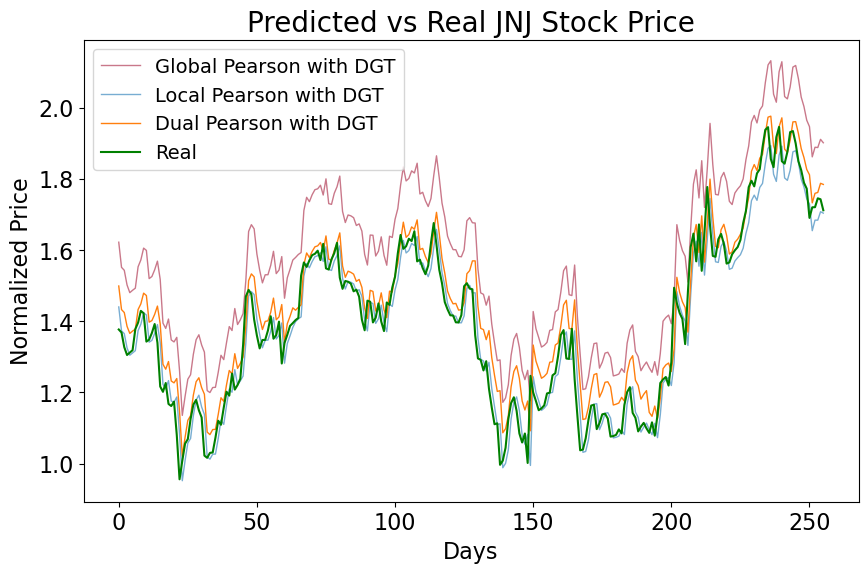

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from cycler import cycler

# Plot regression results on test set
def plot_regression(configs, labels, fig_name, stock_name, preds): # 235 is for Nvidia
    stock_index = stock_lookup[stock_name]
    plt.clf()
    plt.figure(figsize=(10, 6))
    colors = [(0.650, 0.120, 0.240, 0.6),  # red
              (0.122, 0.467, 0.706, 0.6), # blue
              (1.000, 0.498, 0.055), # orange
              (0.580, 0.403, 0.741, 0.6), # purple
              ]
    plt.rc('axes', prop_cycle=cycler('color', colors))

    for (corr_name, corr_scope, gnn), label in zip(configs, labels):
        eval_dataset = get_dataset(corr_name, corr_scope)['test_samples']
        model = get_model(gnn, corr_name, corr_scope, load_weights=True)
        if model is None:
            continue
        model.eval()
        with torch.no_grad():
            if label not in preds:
                if gnn == DCRNN:
                    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
                        y_hats = list(executor.map(lambda snapshot: infer(model, snapshot).cpu(), eval_dataset))
                else:
                    y_hats = list(map(lambda snapshot: infer(model, snapshot).squeeze().cpu(), eval_dataset))
                preds[label] = y_hats
            else:
                y_hats = preds[label]
            ys = [snapshot.y.cpu() for snapshot in eval_dataset]
            targets = ys
            assert(len(y_hats) == len(ys))
            x = np.array(range(len(ys)))
            print(f'{label} Overall MAE: {mae(torch.stack(y_hats, dim=1), torch.stack(ys, dim=1))}')
            ys = np.array([y[stock_index] for y in ys])
            y_hats = np.array([y_hat[stock_index] for y_hat in y_hats])
            print(f'{label} Stock {stock_index} MAE: {mae(torch.tensor(y_hats), torch.tensor(ys))}')
            plt.plot(x, y_hats, label=label, linewidth=1)

    plt.plot(x, ys, label="Real", color='green')
    plt.legend(fontsize=14)
    plt.title(f'Predicted vs Real {stock_name} Stock Price', fontsize=20)
    plt.xlabel('Days', fontsize=16)
    plt.ylabel('Normalized Price', fontsize=16)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    plt.savefig(fig_name)
    return preds, targets

preds = {}
preds, targets = plot_regression([('pcc', 'global', DGT),
                            ('pcc', 'local', DGT),
                           ('pcc', 'dual', DGT)],
                           ['Global Pearson with DGT', 'Local Pearson with DGT', 'Dual Pearson with DGT'], stock_name='NVDA', fig_name='sp500_regression_NVDA.png', preds=preds)
preds, targets = plot_regression([('pcc', 'global', DGT),
                            ('pcc', 'local', DGT),
                           ('pcc', 'dual', DGT)],
                           ['Global Pearson with DGT', 'Local Pearson with DGT', 'Dual Pearson with DGT'], stock_name='JNJ', fig_name='sp500_regression_JNJ.png', preds=preds)

In [105]:
targets = torch.stack(targets, dim=1)
print(targets.shape)

torch.Size([472, 256])


In [106]:
maes = {}
for key, results in preds.items():
    results = torch.stack(results, dim=1)
    maes[key] = [mae(res, y) for res, y in zip(results, targets)]

print(maes.keys())

g_count = []
l_count = []
d_count = []

desired_count = []

for i, (g, l, d) in enumerate(zip(*maes.values())):
    if g < l and g < d and l < d:
        desired_count.append(i)
    if g < l and g < d:
        g_count.append(i)
    elif l < g and l < d:
        l_count.append(i)
    elif d < g and d < l:
        d_count.append(i)


print(f'Global < Local < Dual MAE is true for {len(desired_count)}, Global wins {len(g_count)}, Local wins {len(l_count)}, Dual wins {len(d_count)}')

print("Stocks when Global < Local < Dual MAE")
print([(stock_names[i]) for i in desired_count])
print("Stocks when Global wins")
print([(stock_names[i]) for i in g_count])
print("Stocks when Local wins")
print([(stock_names[i]) for i in l_count])
print("Stocks when Dual wins")
print([(stock_names[i]) for i in d_count])

dict_keys(['Global Pearson', 'Local Pearson', 'Dual Pearson'])
Global < Local < Dual MAE is true for 78, Global wins 114, Local wins 223, Dual wins 135
Stocks when Global < Local < Dual MAE
['ACGL', 'AFL', 'AIG', 'AMAT', 'ANET', 'APH', 'AVGO', 'AXON', 'AZO', 'BKNG', 'BLDR', 'BRK-B', 'CAH', 'CDNS', 'CI', 'CL', 'CMG', 'COR', 'COST', 'CTAS', 'DECK', 'DHI', 'EG', 'EIX', 'ETN', 'FANG', 'FICO', 'FSLR', 'GWW', 'HBAN', 'HES', 'HIG', 'HLT', 'HUBB', 'IBM', 'IRM', 'JBL', 'JNPR', 'JPM', 'K', 'KLAC', 'LEN', 'LLY', 'LRCX', 'MCK', 'MPC', 'MRK', 'MSFT', 'NRG', 'NVDA', 'NXPI', 'OMC', 'ORCL', 'PANW', 'PCAR', 'PFG', 'PH', 'PHM', 'PKG', 'PSX', 'PWR', 'REGN', 'SBUX', 'SMCI', 'SNA', 'STLD', 'TDG', 'TJX', 'TRGP', 'TRV', 'TT', 'UHS', 'URI', 'VLO', 'VRTX', 'WAB', 'WELL', 'XOM']
Stocks when Global wins
['ABBV', 'ACGL', 'AFL', 'AIG', 'AJG', 'AMAT', 'AMGN', 'AMP', 'ANET', 'APH', 'AVGO', 'AXON', 'AXP', 'AZO', 'BK', 'BKNG', 'BLDR', 'BRK-B', 'BRO', 'BSX', 'CAH', 'CAT', 'CB', 'CBOE', 'CDNS', 'CI', 'CL', 'CMG', 'COP',